# Assignment 3

\- Si Nguyen Mai, May 26, 2018 -

In [35]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec

%run Doc2VecHelperFunctions.ipynb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.feature_selection import SelectKBest, SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style("whitegrid")

% matplotlib inline

## Import my pre-processed data frame

Code for preprocessing data is in "Cleaning_Song-dataset" notebook in the "root" directory

There are 2 pre-processed file:
- 'assignment-3_big-dataset.csv': contains lyrics for all kinds of mood
- 'assignment-3_small-dataset.csv': contains lyrics for only 'happy' and 'aggressive', and column 'Index' for corresponding indices in 'assignment-3_big-dataset.csv'

All the lyrics are clean (stop words, punctuation removed)

In [2]:
big_df = pd.read_csv('assignment-3_big-dataset.csv')
print(big_df.shape)
big_df.head()

(20930, 2)


,lyrics_features,moods
0,oppa gangnam style gangnam style najeneun ttas...,"['energetic', 'motivational']"
1,late ve ve lose sleep dream thing babi ve ve p...,['happy']
2,parti rock yeah woo let s parti rock hous toni...,"['happy', 'celebratory', 'rowdy']"
3,alagamun lan weh wakun heya hanun gon alagamun...,"['happy', 'energetic', 'celebratory']"
4,j lo s new generat mr worldwid parti peopl flo...,['energetic']


In [3]:
target_df = pd.read_csv('assignment-3_small-dataset.csv')
print(target_df.shape)
target_df.head()

(3440, 3)


,index,lyrics_features,moods
0,1,late ve ve lose sleep dream thing babi ve ve p...,happy
1,2,parti rock yeah woo let s parti rock hous toni...,happy
2,3,alagamun lan weh wakun heya hanun gon alagamun...,happy
3,5,today don t feel like do just wanna lay bed do...,happy
4,9,don t know turn head walk o don t need make co...,happy


Check the *equality* in sample size between two classes

In [4]:
# The number of 'happy' lyrics:
print(len(target_df[target_df['moods'] == 'happy']))

# The number of 'aggressive' lyrics:
print(len(target_df[target_df['moods'] == 'aggressive']))

1757
1683


In [5]:
labels = np.ravel(target_df['moods'])

labels

array(['happy', 'happy', 'happy', ..., 'happy', 'aggressive', 'happy'], dtype=object)

## Preparing features input 

### Bag of words

In [6]:
count_vect = CountVectorizer()

bow = count_vect.fit_transform(target_df['lyrics_features'])

bow.shape

(3440, 22570)

### TF - IDF

In [7]:
tfidf_vect = TfidfVectorizer()

tf_idf = tfidf_vect.fit_transform(target_df['lyrics_features'])

tf_idf.shape

(3440, 22570)

### Doc2Vec

In [8]:
all_lyrics = big_df['lyrics_features'].tolist()

print(type(all_lyrics))
len(all_lyrics)

<class 'list'>


20930

In [9]:
#convert_lyrics_to_d2v(all_lyrics)

In [10]:
doc2vec_model = Doc2Vec.load('./song_lyrics.d2v')

In [11]:
doc2vec = doc2vec_model[target_df['index']]

doc2vec

array([[ 1.23539937, -1.28101766, -1.48635399, ...,  1.57250249,
         1.25255394,  1.86322331],
       [ 2.20976281, -0.12866332, -2.41090131, ..., -0.2270617 ,
         0.7468949 ,  2.48212528],
       [ 3.03357291, -0.41046563, -0.86521643, ...,  0.09651477,
        -0.23563212,  0.65808886],
       ..., 
       [ 1.61306369,  0.28757182, -2.39796233, ..., -0.78782743,
        -0.6883263 , -0.12553684],
       [ 0.43706188,  0.17893283,  0.37903407, ..., -0.66263926,
         1.11233342,  0.1141317 ],
       [ 0.80377418, -0.89266783, -0.86730605, ..., -1.48051941,
        -0.44940835,  0.12566899]], dtype=float32)

OK. <br>
So now we get 3 sets of feature data from 3 methods: `bow`, `tf_idf`, and `doc2vec`. <br>
Also, our labels array named: `labels`

## Classification

In [110]:
np.random.seed(99)

In [111]:
feat_methods = ['bow', 'tf_idf', 'doc2vec']

In [112]:
train_test_sets = {
    'bow': train_test_split(bow, labels, test_size = 0.3),
    'tf_idf': train_test_split(tf_idf, labels, test_size = 0.3),
    'doc2vec': train_test_split(doc2vec, labels, test_size = 0.3)
}
# In a key - value pair, value is a list in format of [X_train, X_test, y_train, y_test]

In [113]:
def optimizing (estimator, param_grid, train_test_list, n_jobs):
    
    output = {}
    X_train, X_test, y_train, y_test = train_test_list
    
    grid = GridSearchCV(estimator, param_grid, refit = True, n_jobs = n_jobs)
    grid.fit(X_train, y_train) 
    
    output['estimator'] = grid.best_estimator_
    output['params'] = grid.best_params_
    output['prediction'] = grid.predict(X_test)
    
    return output

In [16]:
def estimator_searching (init_classifiers, param_grids, train_test_list, n_jobs):
    
    classifiers = {method : {} for method in init_classifiers.keys()}
    
    for method in classifiers.keys():
        
        estimator = init_classifiers [method]
        param_grid = param_grids [method]
        
        classifiers[method] = optimizing(estimator, param_grid, train_test_list, n_jobs)
    
    return classifiers

In [30]:
def accuracy_plot (classifiers, train_test_list, palette = "muted", ax = None):
    methods = []
    accuracies = []
    models = [] 
    
    for method, attribute in classifiers.items():

        methods = methods + [method]*len(attribute.keys())
        y_true = train_test_list[method][3]
        
        for model, result in attribute.items():
            
            models.append(model)
            accuracies.append(accuracy_score(y_true, result['prediction']))

    df = pd.DataFrame({'method': methods, 'accuracy': accuracies, 'model': models})
    plot  = sns.factorplot(x = 'method', y = 'accuracy', hue = 'model', data = df, 
                           size = 6, palette = palette, ax = ax)
    plot.set(ylim = (0.5, 1))
    
    return plot

In [64]:
def show_selected_params (classifiers, train_test_list):
    
    for method, attribute in classifiers.items():
        print(method + "\n")
        
        y_true = train_test_list[method][3]
        
        for model, result in attribute.items():
            print("    Accuracy in {} model: {}".format(model, accuracy_score(y_true, result['prediction'])))
            print(" ...with selected params: {} \n".format(result['params']))
        
        print("\n")

### Find best parameters for all KNN, linear logistic regression, SVM, and random forest models

Initially, since the number of features from any of 3 NLP-processing methods we used is very large, particularly those from Bag-of-words and TF-IDF, thus I expected that KNN would not perform very well due to the curse of dimensonality.

Other three models would give higher scores, but I expected more in Random Forest, as it outperformed logistic regression and SVM in the last assignment. However, I was not very sure about this.

In [17]:
init_classifiers_0 = {
        'knn': KNeighborsClassifier(),
        'logreg': LogisticRegression(),
        'svm': SVC(),
        'rfc': RandomForestClassifier()
    }
    
param_grids_0 = {
    'knn': {'n_neighbors': [5, 10, 25, 50]},
    'logreg': 
    {
        'solver': ['liblinear'], 
    }, 
    'svm': 
    {
        'C': [0.1, 1, 10],
        'gamma': [1, 0.1, 0.01, 0.001]
    },
    'rfc': 
    {
        'n_estimators': [5, 10, 100],
        'min_samples_split': [2, 3, 4, 5, 10],
        'max_features': ['sqrt', 'log2', 'auto']
    }
}

In [18]:
classifiers_0 = { method : estimator_searching(init_classifiers_0, param_grids_0, 
                                               train_test_sets[method], n_jobs = 2) 
                 for method in feat_methods }

In [20]:
len(classifiers_0.keys())

3

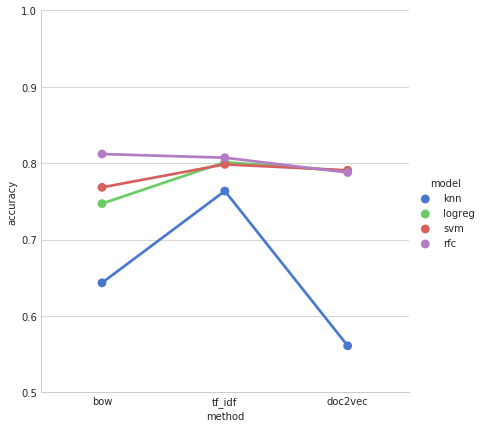

In [31]:
accuracy_plot(classifiers_0, train_test_sets)

Results for KNN  and Random Forest are exactly what I expected!

It is also very interesting that KNN on TF-IDF features performed much more better than on BOW or Doc2Vec.

### Reducing the number of features by `SelectKBest`

Just to see how things gonna be with KNN

In [36]:
init_classifiers_1 = {}

for method, attribute in classifiers_0.items():
    init_classifiers_1[method] = {}
    
    for model, result in attribute.items():
        init_classifiers_1[method][model] = Pipeline([ ('fs', SelectKBest()), ('clf', clone(result['estimator'])) ])
                                                      
    
param_grids_1 = {
    'knn': {'fs__k': [10, 25, 50, 75, 100]},
    'logreg': {'fs__k': [10, 25, 50, 75, 100]}, 
    'svm': {'fs__k': [10, 25, 50, 75, 100]},
    'rfc': {'fs__k': [10, 25, 50, 75, 100]}
}

In [37]:
classifiers_1 = { method : estimator_searching(init_classifiers_1[method], param_grids_1, 
                                               train_test_sets[method], n_jobs = 2) 
                 for method in feat_methods }

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

Got warning that some features are constant.

I think this is still fine as it only tell us that there are features where there is no difference between classes (actually, between all individual samples), and anyway, those features are not selected.

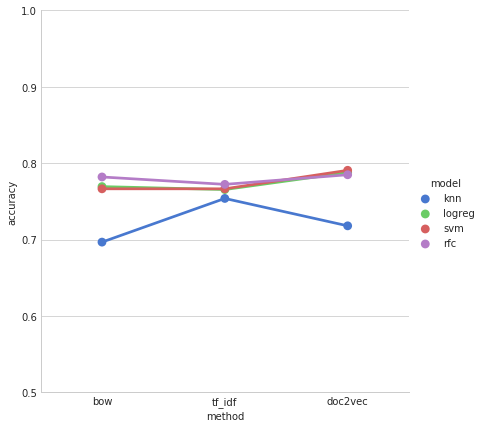

In [39]:
accuracy_plot(classifiers_1, train_test_sets)

Cool.

Accuracy scores in KNN models increased dramatically after feature selection.

In [46]:
show_selected_params(classifiers_1, train_test_sets)

bow

    Accuracy in knn model: 0.6967054263565892
 ...with selected params: {'fs__k': 100} 

    Accuracy in logreg model: 0.7693798449612403
 ...with selected params: {'fs__k': 100} 

    Accuracy in svm model: 0.7664728682170543
 ...with selected params: {'fs__k': 100} 

    Accuracy in rfc model: 0.7819767441860465
 ...with selected params: {'fs__k': 100} 



tf_idf

    Accuracy in knn model: 0.7538759689922481
 ...with selected params: {'fs__k': 25} 

    Accuracy in logreg model: 0.7655038759689923
 ...with selected params: {'fs__k': 100} 

    Accuracy in svm model: 0.7664728682170543
 ...with selected params: {'fs__k': 100} 

    Accuracy in rfc model: 0.7722868217054264
 ...with selected params: {'fs__k': 75} 



doc2vec

    Accuracy in knn model: 0.7180232558139535
 ...with selected params: {'fs__k': 25} 

    Accuracy in logreg model: 0.7877906976744186
 ...with selected params: {'fs__k': 50} 

    Accuracy in svm model: 0.7906976744186046
 ...with selected params: {'fs__k

### Focus in Random Forest and try optimize it with `SelectFromModel`

In [57]:
init_rfc = { method : {'rfc': Pipeline([ ('fs', SelectFromModel(classifiers_0[method]['rfc']['estimator'])), 
                                        ('clf', clone(classifiers_0[method]['rfc']['estimator'])) ]) 
                     } 
            for method in feat_methods}
                                      
param_grids_rfc = { 'rfc': {'fs__threshold': ['median', 'mean']} }

In [58]:
init_rfc.keys()

dict_keys(['bow', 'tf_idf', 'doc2vec'])

In [59]:
classifiers_rfc = { method : estimator_searching(init_rfc[method], param_grids_rfc, 
                                               train_test_sets[method], n_jobs = 2) 
                 for method in feat_methods }

In [65]:
show_selected_params(classifiers_rfc, train_test_sets)

bow

    Accuracy in rfc model: 0.811046511627907
 ...with selected params: {'fs__threshold': 'mean'} 



tf_idf

    Accuracy in rfc model: 0.8178294573643411
 ...with selected params: {'fs__threshold': 'median'} 



doc2vec

    Accuracy in rfc model: 0.7732558139534884
 ...with selected params: {'fs__threshold': 'median'} 





### Multinomial Naive Bayes for Bag-of-words and TF-IDF

> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Source: [Scikit-learn doc in MultinomialNB](The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.)

In [100]:
from sklearn.naive_bayes import MultinomialNB

In [125]:
init_NB = { method : {'multinomial_NB': Pipeline([ ('fs', SelectKBest()), ('clf', MultinomialNB()) ]) } 
            for method in feat_methods[:2]
           }
                                      
param_grids_NB = { 'multinomial_NB': {
    'fs__k': [3500, 4000, 5000, 5500, 6000],
    'clf__alpha': [0.1, 0.6, 0.7, 0.75, 1, 2, 5]
} }

In [126]:
classifiers_NB = { method : estimator_searching(init_NB[method], param_grids_NB, 
                                               train_test_sets[method], n_jobs = 2) 
                 for method in feat_methods[:2] }

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

In [127]:
show_selected_params(classifiers_NB, train_test_sets)

bow

    Accuracy in multinomial_NB model: 0.7965116279069767
 ...with selected params: {'clf__alpha': 5, 'fs__k': 5500} 



tf_idf

    Accuracy in multinomial_NB model: 0.8207364341085271
 ...with selected params: {'clf__alpha': 0.7, 'fs__k': 3500} 





Multinomial Naive Bayes works very well on BOW and TF-IDF.

My last work on this section (but it was accidentally lost) gave little higher scores, around 81% - 82% for both BOW and TF-IDF

## Use n-grams in Bag-of-words and TF-IDF

In [122]:
digram_count_vect = CountVectorizer(ngram_range = (1, 2))
digram_bow = digram_count_vect.fit_transform(target_df['lyrics_features'])
print(digram_bow.shape)

digram_tfidf_vect = TfidfVectorizer(ngram_range = (1, 2))
digram_tf_idf = digram_tfidf_vect.fit_transform(target_df['lyrics_features'])
print(digram_tf_idf.shape)

(3440, 214458)
(3440, 214458)


In [128]:
digram_train_test = {
    'bow': train_test_split(digram_bow, labels, test_size = 0.3),
    'tf_idf': train_test_split(digram_tf_idf, labels, test_size = 0.3),
}

In [130]:
init_digram = { method : {'multinomial_NB': Pipeline([ ('fs', SelectKBest()), ('clf', MultinomialNB()) ]) } 
            for method in feat_methods[:2]
           }
                                      
param_grids_digram = { 'multinomial_NB': {
    'fs__k': [3500, 4000, 5000, 5500, 6000],
    'clf__alpha': [0.1, 0.6, 0.7, 0.75, 1, 2, 5]
} }

In [134]:
classifiers_digram = { method : estimator_searching(init_digram[method], param_grids_digram, 
                                               digram_train_test[method], n_jobs = 2) 
                 for method in feat_methods[:2] }

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [0 0 0 ..., 0 0 0] are constant.
  UserWarning)
/home/singuyen/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:1

In [135]:
show_selected_params(classifiers_digram, train_test_sets)

bow

    Accuracy in multinomial_NB model: 0.5213178294573644
 ...with selected params: {'clf__alpha': 5, 'fs__k': 6000} 



tf_idf

    Accuracy in multinomial_NB model: 0.500968992248062
 ...with selected params: {'clf__alpha': 0.6, 'fs__k': 5500} 





Using n-grams seems to add more noises to the data ...